# Project Premature Stop Codons in *Arabidopsis thaliana*



To manage live in an ecosystem organisms need to adapt to the specific abiotic and biotic factors around them. Especially for plants adaptation is important because they can not change their habitat during their lifespan. Adaptation can happen through multiple changes on cell, tissue and organism level, but the fundamental process that drive adaptation on the smallest scale are mutations. There are three categories of mutations, which have different effects on the process of transkription of DNA to RNA and the translation from the RNA to the protein. The first category of mutations are synonymous mutations. Synonymous mutations are point mutations in the DNA, which lead to a change in the  sequence of basepairs. **TODO ongoing introduction**

## Setup Project structure

## Ara11-Annotation

### Analysing positions of gene locations 

For determining length or position of genes or RNAs we need information about the start of the 5'UTR, the start of the coding sequence, the stop of the coding sequence, the stop of the 3' UTR and the orientation of the gene on the DNA strand for each single gene in *A. thaliana*. For getting a detailed look at the different genes we actually look at the start  and stop of the protein as well as the UTR regions. This leads to multiple entries for different splice variants for one gene. Different splicing variants result in different protein start and stop and can also result in different 5'UTR and 3'UTR regions depending on the annotation in the Araport 11 file. We store all genes, which don't have a protein as a result for example miRNAs in a different table. For them only the information of where the gene starts and ends is available. We also generate a table for transposons, which contains the start and stop known for these transposons.

In [1]:
%run ../scripts/Ara11_Annotation.py

In [2]:
ara11_genes

,Name,Orientation,Start_5UTR,Stop_5UTR,Start_Protein,Stop_Protein,Start_3UTR,Stop_3UTR
0,AT1G01010.1,+,3631,3759,3760,5630,5631,5899
1,AT1G01020.1,-,8667,9130,6915,8666,6788,6914
2,AT1G01020.2,-,8667,8737,7315,8666,6788,7069
3,AT1G01020.3,-,8443,8464,6915,8442,6788,6914
4,AT1G01020.4,-,8594,9130,6915,8442,6788,6914
...,...,...,...,...,...,...,...,...
48354,ATMG01350.1,+,NaN,NaN,346757,347194,NaN,NaN
48355,ATMG01360.1,-,NaN,NaN,349830,351413,NaN,NaN
48356,ATMG01370.1,-,NaN,NaN,360717,361052,NaN,NaN
48357,ATMG01400.1,+,NaN,NaN,363725,364042,NaN,NaN


## Premature-Stop Attributes

### Approach 1: Geneexpression Differences

For the further analysis we need to have a functional dataset where we are sure that the premature stop codons have actual impact on the plant. For that we thought, that we compare gene expression patterns between the wildtype accessions and the ko-mutant accessions (containg the premature stop codons) and take all premature stop codons, which have a significant difference in these two groups. For that we use RNA-Seq data, which is also available from the 1001 Genomes Project and contains transcriptoms of 727 *A. thaliana* accessions. 

#### Preprocessing

To make the raw data possible to analyze with the Python programming language, the vcf-format is processed to a standard csv-file format. This is done in the R script Preprocessing.r

For a comfortable further analysis we need to simplify the gt-section in a more numerical format as well as filtering the gt-section and the expression dataset for their overlap. The RNA-Seq dataset has 727 different accessions of *A.thaliana*, which have 665 common accessions, where we have RNA-seq and genomic information.

In [3]:
%run ../scripts/Preprocessing_Genexpression.py

#### Confidential Dataset 

We try to categorize the premature stop codons in 3 different classe: unsignificant gene expression change, significant decrease in gene expression and significant increase in gene expression.If a Premature Stop Codon is introduced in an ecotype of *A.thaliana* the gene expression should be significantly reduced. We calculate therefore the number of accessions with and without mutation (WT and ko-Mutant) and their mean.

Important facts (problems) about the analysis: The first problem we face for our analysis is the different annotations used for *A.thaliana*. Araport11 is the most recent annotation of *A. thaliana*, which detects lots of new genes in previously believed non-coding regions. But unfortunately the RNA-Seq data of *A. thaliana* was mapped to the older version which is called TAIR10. Our approach will be based on the analysis of the genomic premature stop codons mapped (annotated) to the Araport11 annotation and selecting just these premature stop codons which are included in our RNA-Seq dataset (annotated with TAIR10). We calculate the number of wildtype and ko-mutant accessions for each premature stop codon and also store the names of these accessions. Then we calculate their mean of expression and the standard deviation. Between the steps we filter out all premature stop codons, which either have no wildtype accession or no ko-mutant accession. We select all significant premature stop codons, which have either passed a 0.05 threshold or a bonferroni corrected threshold. And select to different types. Premature stop codons, which lead to a significant decrease in gene expression and on the other hand a significant increase of gene expression. Until now we analysed the gene expression for every single premature stop codon. Since we can only compare the gene expression on gene level we combine all significant premature stop codons from one gene as a last step. 

In [19]:
%run ../scripts/Geneexpression_Differences.py

Full List of Premature Stop Codons Ara11 contain:  29029
Filtered List of Premature Stop Codons after removing unknown genes of Ara11:  17046
The final list of Premature Stop Codons before calculating the pvalues includes:  7124
Significant premature stop codons with increase of gene expression  742
Significant premature stop codons with decrease of gene expression  949
Bonferroni corrected significant premature stop codons with increase of gene expression  269
Bonferroni corrected significant premature stop codons with decreased of gene expression  247
After merging the single stop premature stop codons on a gene based level:  235


First we look at some common features of the premature stop codons in the 1001 Genomes project.

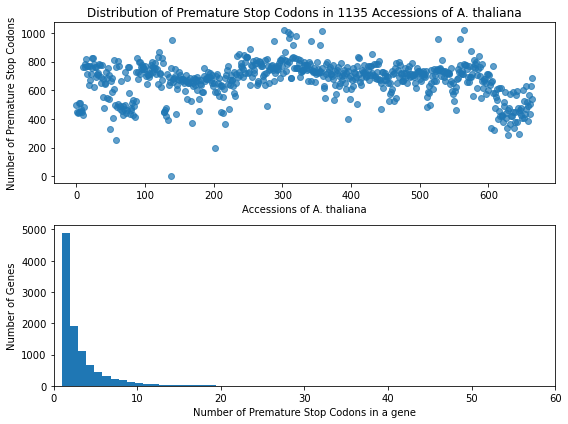

In [5]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 

gt_section = pd.read_csv('../data/preprocessed/GT_Section_Numeric_Overlap.csv', index_col=0)
stop_table_plot = pd.read_csv('../data/preprocessed/Stop_Table_Full.csv', index_col=0)
genes = np.unique(stop_table_plot.Gene)

numbers_gene_count = []
for gene in genes:
    subset = stop_table_plot[stop_table_plot['Gene'] == gene]
    numbers_gene_count.append(subset.shape[0])

numbers_premature_stops = gt_section.sum(axis=1)
accessions = np.arange(0, len(gt_section.index.values))
fig = plt.figure(figsize=(8, 6))
gs = fig.add_gridspec(2, 1)
ax1 = fig.add_subplot(gs[0, 0])
ax1.scatter(accessions, numbers_premature_stops, alpha=0.7)
ax1.set_xlabel('Accessions of A. thaliana')
ax1.set_ylabel('Number of Premature Stop Codons')
ax1.set_title('Distribution of Premature Stop Codons in 1135 Accessions of A. thaliana')
ax2 = fig.add_subplot(gs[1, 0])
ax2.hist(numbers_gene_count, bins=60);
ax2.set_xlim(0, 60);
ax2.set_xlabel('Number of Premature Stop Codons in a gene')
ax2.set_ylabel('Number of Genes')
fig.tight_layout()
output_file = "figures/Distribution_Premature_Stop_Codons.png"
plt.savefig(output_file, dpi=700, facecolor='w')
plt.show()


Now we can have a illustration of the three categories of gene expression differences:

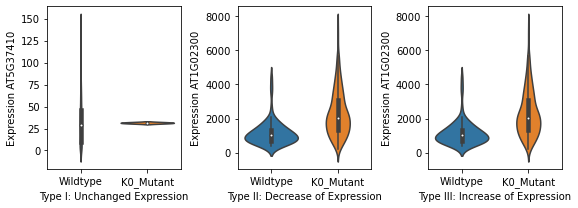

In [18]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

small_att = stop_list_bonferroni_low_expression.iloc[0, :]
wildtype = expression_overlap.loc[small_att.WT_acc, small_att.Gene]
ko_mutant = expression_overlap.loc[small_att.KO_acc, small_att.Gene]
plot_df = pd.DataFrame(columns=['Type', 'Expression'])
for plant in range(wildtype.shape[0]):
    new_row = {'Type': ['Wildtype'], 'Expression': [wildtype.iloc[plant]]}
    new = pd.DataFrame.from_dict(new_row)
    plot_df = pd.concat([plot_df, new], ignore_index=True)

for plant in range(ko_mutant.shape[0]):
    new_row = {'Type': ['K0_Mutant'], 'Expression': [ko_mutant.iloc[plant]]}
    new = pd.DataFrame.from_dict(new_row)
    plot_df = pd.concat([plot_df, new], ignore_index=True)

plot_df['Expression'] = plot_df.Expression.astype('float')

big_p_subset = stop_table[stop_table['pvalue'] == stop_table['pvalue'].max()]
big_att = big_p_subset.iloc[0, :]
wildtype = expression_overlap.loc[big_att.WT_acc, big_att.Gene]
ko_mutant = expression_overlap.loc[big_att.KO_acc, big_att.Gene]
plot_df2 = pd.DataFrame(columns=['Type', 'Expression'])
for plant in range(wildtype.shape[0]):
    new_row = {'Type': ['Wildtype'], 'Expression': [wildtype.iloc[plant]]}
    new = pd.DataFrame.from_dict(new_row)
    plot_df2 = pd.concat([plot_df2, new], ignore_index=True)

for plant in range(ko_mutant.shape[0]):
    new_row = {'Type': ['K0_Mutant'], 'Expression': [ko_mutant.iloc[plant]]}
    new = pd.DataFrame.from_dict(new_row)
    plot_df2 = pd.concat([plot_df2, new], ignore_index=True)

plot_df2['Expression'] = plot_df2.Expression.astype('float')

over_att = stop_list_bonferroni_high_expression.iloc[0, :]
wildtype = expression_overlap.loc[over_att.WT_acc, over_att.Gene]
ko_mutant = expression_overlap.loc[over_att.KO_acc, over_att.Gene]
plot_df3 = pd.DataFrame(columns=['Type', 'Expression'])

for plant in range(wildtype.shape[0]):
    new_row = {'Type': ['Wildtype'], 'Expression': [wildtype.iloc[plant]]}
    new = pd.DataFrame.from_dict(new_row)
    plot_df3 = pd.concat([plot_df3, new], ignore_index=True)

for plant in range(ko_mutant.shape[0]):
    new_row = {'Type': ['K0_Mutant'], 'Expression': [ko_mutant.iloc[plant]]}
    new = pd.DataFrame.from_dict(new_row)
    plot_df3 = pd.concat([plot_df3, new], ignore_index=True)

plot_df3['Expression'] = plot_df3.Expression.astype('float')
label1 = "Expression " + str(small_att.Gene)
label2 = "Expression " + str(big_att.Gene)
label3 = "Expression " + str(over_att.Gene)
fig = plt.figure(figsize=(8, 3))
gs = fig.add_gridspec(1, 3)

ax = fig.add_subplot(gs[0, 0])
sns.violinplot(x='Type', y='Expression', data=plot_df2)
ax.set_xlabel("Type I: Unchanged Expression")
ax.set_ylabel(label2)
ax = fig.add_subplot(gs[0, 1])
sns.violinplot(x='Type', y= 'Expression', data=plot_df)
ax.set_xlabel("Type II: Decrease of Expression")
ax.set_ylabel(label1)
ax = fig.add_subplot(gs[0, 2])
sns.violinplot(x='Type', y='Expression', data=plot_df3)
ax.set_xlabel("Type III: Increase of Expression")
ax.set_ylabel(label3)
fig.tight_layout()
output_file = "figures/Cathegories_Premature_Stop_Codons.png"
plt.savefig(output_file, dpi=700, facecolor='w')
plt.show()

In [7]:
gene_premature_stop_list

,Gene,Prem_Stop_Codons_Num,WT_num,WT_acc,KO_num,KO_acc,na_Num,na_Acc
0,AT1G02300,1,84,"[424.0, 428.0, 915.0, 1066.0, 1829.0, 2171.0, ...",566,"[108.0, 139.0, 159.0, 265.0, 350.0, 351.0, 403...",15,"[9518.0, 9661.0, 9666.0, 9738.0, 9788.0, 9946...."
1,AT1G03710,1,502,"[108.0, 139.0, 159.0, 265.0, 350.0, 351.0, 410...",2,"[9542.0, 9549.0]",161,"[403.0, 1317.0, 1925.0, 5210.0, 5395.0, 5717.0..."
2,AT1G04400,1,562,"[108.0, 139.0, 265.0, 350.0, 351.0, 403.0, 506...",82,"[424.0, 915.0, 997.0, 1002.0, 1066.0, 1317.0, ...",21,"[159.0, 410.0, 428.0, 5023.0, 5874.0, 5993.0, ..."
3,AT1G04580,1,395,"[108.0, 139.0, 159.0, 265.0, 351.0, 403.0, 410...",231,"[763.0, 768.0, 801.0, 1002.0, 1158.0, 1872.0, ...",31,"[350.0, 424.0, 428.0, 630.0, 5720.0, 5768.0, 5..."
4,AT1G05740,1,614,"[139.0, 159.0, 265.0, 350.0, 351.0, 403.0, 410...",2,"[1317.0, 6424.0]",49,"[108.0, 1002.0, 5104.0, 5984.0, 6008.0, 6108.0..."
...,...,...,...,...,...,...,...,...
230,AT5G54390,1,530,"[108.0, 159.0, 350.0, 351.0, 403.0, 410.0, 428...",78,"[1002.0, 5349.0, 5860.0, 6099.0, 6107.0, 6220....",57,"[139.0, 265.0, 424.0, 932.0, 5023.0, 5276.0, 5..."
231,AT5G58220,1,573,"[159.0, 265.0, 350.0, 351.0, 403.0, 410.0, 424...",66,"[870.0, 997.0, 1829.0, 1925.0, 1954.0, 2016.0,...",26,"[108.0, 139.0, 915.0, 5779.0, 6744.0, 6974.0, ..."
232,AT5G59270,1,444,"[108.0, 139.0, 159.0, 265.0, 350.0, 351.0, 410...",137,"[506.0, 687.0, 728.0, 801.0, 932.0, 1066.0, 13...",84,"[403.0, 428.0, 763.0, 768.0, 915.0, 1741.0, 19..."
233,AT5G62998,1,642,"[108.0, 139.0, 159.0, 265.0, 350.0, 351.0, 410...",6,"[6106.0, 6111.0, 6201.0, 6974.0, 9409.0, 9421.0]",17,"[403.0, 5210.0, 6296.0, 6445.0, 9510.0, 9630.0..."


### Approach 2: Calculation of length of mRNA

The second approach is based on the calculation of the remaining length of the mRNA. The idea behind it is based on the hypothesis, that a stop codon at the end of a gene is not so severe then right at the start. If the protein is very truncated it should be unfunctional. That means, that we calculate the relative length in the following analysis and select genes which are in a threshold of 30% percent and a second threshold which includes as in the first approach a list of 247 premature stops. 

In [16]:
%run ../scripts/Length_mRNA.py

Second_Threshold:  0.47953964194373405


In [12]:
results_table

,Chrom,Pos,Gene,Start_Protein,Stop_Protein,Length,Relative_Length
0,1,40316,AT1G01070,38898,40877,1418,71.65235
2,1,57397,AT1G01120,57392,58978,5,0.315259
3,1,61925,AT1G01130,61905,63811,20,1.049318
4,1,64403,AT1G01140,64398,67512,5,0.160565
5,1,83241,AT1G01190,83045,84864,196,10.775151
...,...,...,...,...,...,...,...
29024,5,26898888,AT5G67411,26898401,26899097,487,69.971264
29025,5,26932323,AT5G67480,26931055,26932496,1268,87.994448
29026,5,26935820,AT5G67500,26935223,26937650,597,24.598269
29027,5,26954660,AT5G67570,26952352,26955480,2308,73.785166


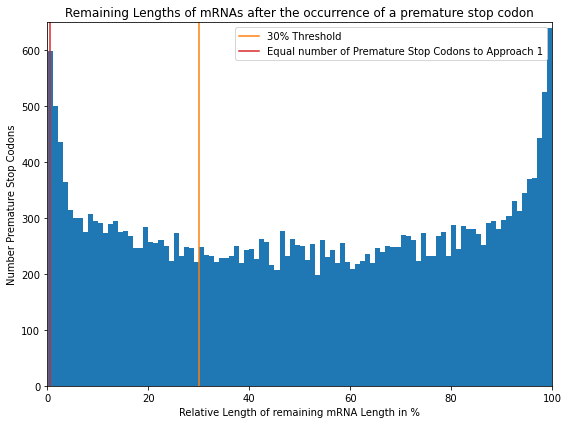

In [17]:
import matplotlib.pyplot as plt

relative_length = results_table.Relative_Length

fig = plt.figure(figsize=(8, 6))
gs = fig.add_gridspec(1, 1)
ax1 = fig.add_subplot(gs[0, 0])
ax1.hist(relative_length, bins=100);
ax1.set_xlim(0,100)
ax1.set_ylim(0,650)
ax1.set_xlabel('Relative Length of remaining mRNA Length in %')
ax1.set_ylabel('Number Premature Stop Codons')
ax1.set_title('Remaining Lengths of mRNAs after the occurrence of a premature stop codon')
plt.axvline(x=30, color='C1', label='30% Threshold')
plt.axvline(x=0.47, color='C3', label='Equal number of Premature Stop Codons to Approach 1')
plt.legend()
fig.tight_layout()
output_file = "figures/Remaining_Length.png"
plt.savefig(output_file, dpi=700, facecolor='w')
plt.show()


### Compare the two Approachs

Study how much overlap the two approaches do have and visualize it in an venn diagramm. 

In [ ]:
%run Compare_Approaches.py

## Control with Synonymous and Non-Synonymous Mutations